# Preprocessing Audio Files of Robotic Connector Mating Processes and Automated Labeling of Click-Events (for the HVA 280 connector)

In [8]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys

In [36]:
# import necessary functions from the folder "05_Utilities"

cwd = str(Path.cwd()) # current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent) # parent dir of the current working directory, should be the project directory
utilities_dir_full_pat = os.path.join(parent_dir, "05_Utilities") # full path to the "05_Utilities" folder

# import moduls
sys.path.append(utilities_dir_full_pat) # add the path to the "05_Utilities" folder to the sys.path list
from getMelSpectrogram import getMelSpectrogram # modul for audio file processing and mel-spectrogram generation
from plotSpectrogram import spectrogramPlotter # modul for mel-spectrogram visualization

# make instances of the classes
getMelSpectrogram = getMelSpectrogram()
spectrogramPlotter = spectrogramPlotter()

## 1. Read in audio files, process audio data, and generate mel-scaled spectrograms

In [10]:
# list all audio file datasets in folder "01_Data/01_audioDatasets"

audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets) # sort the list of audio datasets
else:
    print("\"01_audioDatasets\" directory does not exist or is not in the correct location.")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [11]:
# select dataset (from datasets recorded without additional noise)
# dataset_num = 2 for HVA 280 connector

dataset_num = 2
print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  03_HVA280


In [14]:
# add audio files from selected dataset to a list

# sorting function by numbers in the name
def sort_key_func(file_name):
        numbers = re.findall(r'_(\d+)', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

audio_dataset_dir = os.path.join(cwd, audio_datasets_main_dir_name) + "/" + audio_datasets[dataset_num]
audio_files = [f for f in os.listdir(audio_dataset_dir) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files, key=sort_key_func)
#audio_files_sorted = sorted(audio_files)

print(f"Dataset length: {len(audio_files_sorted)}")

i = 0
print("First 5 files in the selected dataset:")
while i < 5:
    print(audio_files_sorted[i])
    i += 1

Dataset length: 60
First 5 files in the selected dataset:
HVA280_1.m4a
HVA280_2.m4a
HVA280_3.m4a
HVA280_4.m4a
HVA280_5.m4a


In [15]:
# constant values (used in real-time detection as well)

# original sampling rate of the microphone is 48 kHz, the frequency response from the microphone specifications is 20 Hz to 20 kHz which indicates a max sampling rate of 40 kHz (Nyquist theorem)
# however, for a sampling rate of 40 kHz, a darker zone can be seen on the top of the spectrogram meaming the microphone cannot capture frequencies above a certain limit
# thus, the sampling rate is set to 32 kHz to avoid this issue, at this sampling rate there is no dark zone on the top of the spectrogram
sampling_rate = 32000 # Hz

chunk_size = 4096 # number of samples in one chunk of audio data

resolution = 0.016 # seconds, time intervall for each column in the spectrogram

spectrogram_columns_per_chunk = (chunk_size / sampling_rate) / resolution # number of spectrogram columns for one chunk of audio data
# 8 spctogram columns per chunk in case of a resolution of 0.016s, sampling rate of 32000 Hz and chunk size of 4096 samples

hop_length = int(resolution * sampling_rate) # the number of samples between successive frames in the STFT
n_mels = 128 # number of mel bands (rows in the mel-scaled spectrogram), 128 is a common value

f_min = 20 # minimum frequency in Hz, from the microphone specification
f_max = 14000 # maximum frequency in Hz, the microphone has a max frequency response of 20 kHz, however, the sampling rate is 32 kHz, so the max frequency can be 16 kHz or lower

In [16]:
# constant values (used in real-time detection as well)

# dB_ref and a_squere_min is choosen based on the min and max values of amplitude squere in the dataset

dB_ref = 1e3 # reference value for dB conversion
a_squere_min = 1e-12 # larger than 0 to avoid log(0)
top_dB_abs = abs(10*np.log10(a_squere_min)) # maximum dB value -> 10*log(a_squere_min) = -120

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/05_Utilities/getMelSpectrogram.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


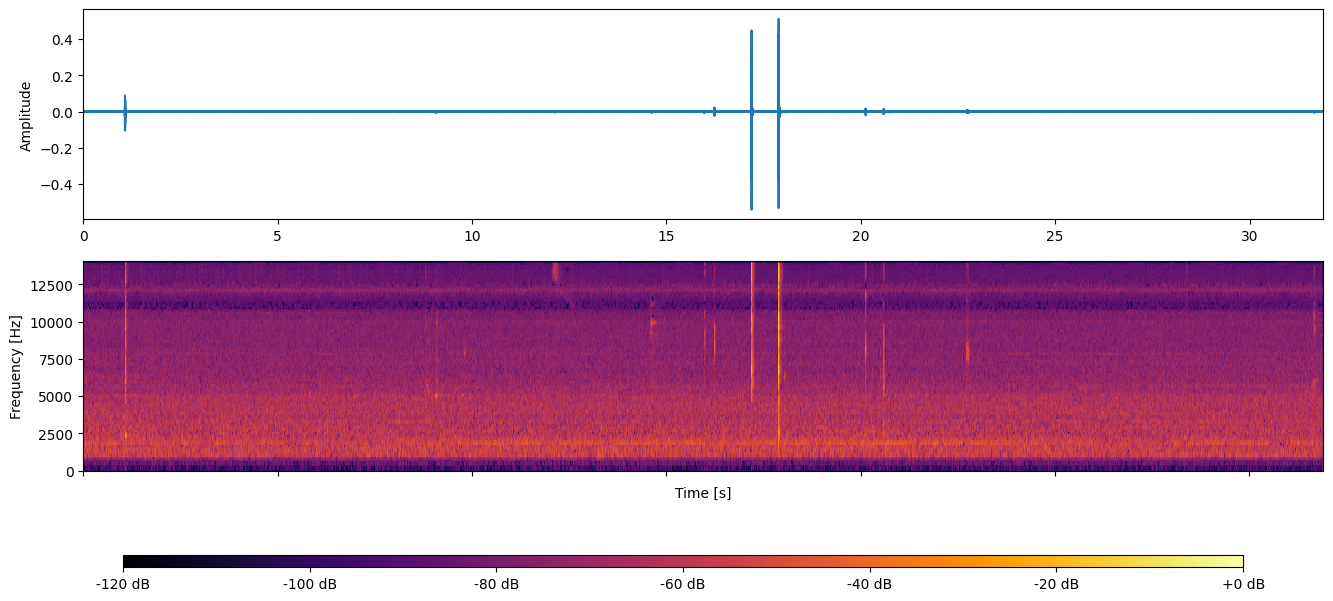

In [29]:
# plot the wave and mel spectrogram of an audio file from the selected dataset

file_id_num = 5 # selected file ID number

if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num])
    signal, time, D_mel, D_mel_dB = getMelSpectrogram.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range")

## 2. Automated labeling - find click peaks in the wave files
Note: This works only for files where click peak can be easily detected, i.e. no other noise with higher amplitude is present in the wavefrom

In [31]:
# calculating peak times for each audio file in the selected dataset based on the maximum absolute value of the signal amplitude

# calculate peak time of the click event for each audio file in the selected dataset
def calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, hop_length, n_mels, dB_ref):
    signals = [] # audio wave forms
    signal_times = [] # time stamps in seconds for all samples in an audio file 
    peak_times_1 = [] # in seconds, time of largerst peak in each signal
    peak_times_2 = [] # in seconds, time of 2nd largest peak in each signal
    spectrograms = []

    for i in range(len(audio_files_sorted)):
        audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
        signal, time, D_mel, D_mel_dB = getMelSpectrogram.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
        signals.append(signal)
        signal_times.append(time)
        spectrograms.append(D_mel_dB)

        # search abs max value of the signal within the search interval

        search_interval_min = 0 # search from the start of the audio signals
        search_interval_min_index = search_interval_min * sampling_rate
        search_interval_max_index = len(signal)

        j = search_interval_min_index
        peak_index_1 = j
        while j < search_interval_max_index-1:
            if signal[j+1] > signal[peak_index_1]:
                peak_index_1 = j+1
            j = j + 1
        
        peak_time_1 = peak_index_1 / sampling_rate
        peak_times_1.append(peak_time_1)

        # search abs max value of the signal within the search interval excluding the epsilon environment of first peak

        eps_interval = 0.1 # in seconds
        eps_interval_index_values = int(eps_interval * sampling_rate) # number of samples excluded from search in + and - direction
        z = search_interval_min_index
        peak_index_2 = z
        while z < search_interval_max_index-1:
            if (z < peak_index_1 - eps_interval_index_values) or (z > peak_index_1 + eps_interval_index_values):
                if signal[z+1] > signal[peak_index_2]:
                    peak_index_2 = z+1
            z = z + 1

        peak_time_2 = peak_index_2 / sampling_rate
        peak_times_2.append(peak_time_2)


    return signals, signal_times, peak_times_1, peak_times_2, spectrograms 

# get the signals, signal times and peak times for the selected dataset
signals, signal_times, peak_times_1, peak_times_2, spectrograms  = calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, hop_length, n_mels, dB_ref)

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/05_Utilities/getMelSpectrogram.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


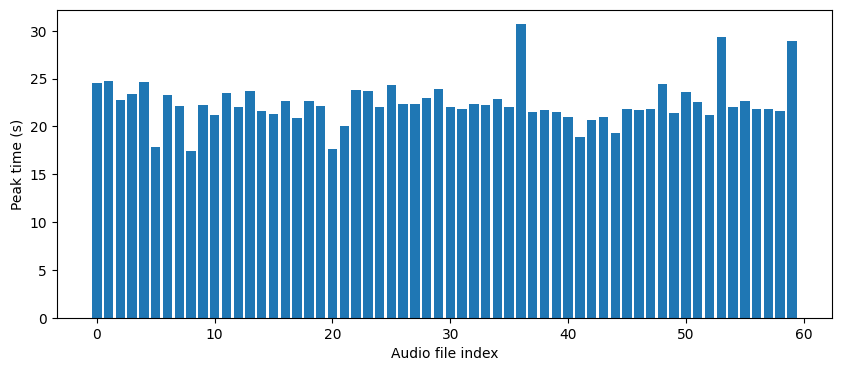

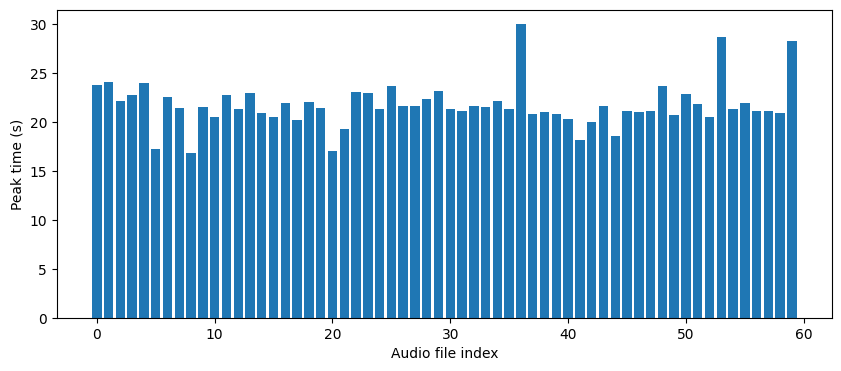

Mean of the peak times in the peg-in-hole process: 22.403921354166666


In [37]:
# check if the peak time are around the same time for all audio files -> same robotic peg-in-hole event was recorded with nearly the same start and stop times
# outliers should be checked

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_times_1)), peak_times_1)
plt.xlabel('Audio file index')
plt.ylabel('Peak time (s)')

# plot for second peak times

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_times_2)), peak_times_2)
plt.xlabel('Audio file index')
plt.ylabel('Peak time (s)')
plt.show()


print(f"Mean of the peak times in the peg-in-hole process: {np.mean(peak_times_1)}")

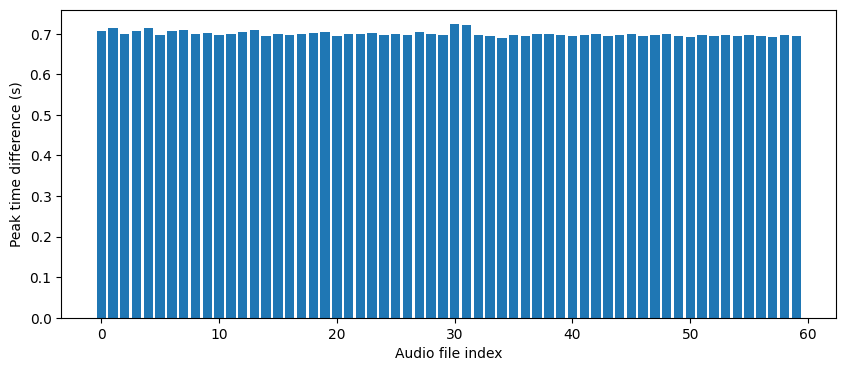

In [38]:
# plot time absolut differences between the peak times of the first and second peak

peak_time_diff = abs(np.array(peak_times_1) - np.array(peak_times_2))

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_time_diff)), peak_time_diff)
plt.xlabel('Audio file index')
plt.ylabel('Peak time difference (s)')
plt.show()

In [39]:
# plot the signal interval around the peak time of the click event for the same audio file in the selected dataset as the spectrogram plot above

time_interval = (chunk_size/sampling_rate) * 4 # this will be the window size in the real time detection --> 4 chunks with 4096 samples each --> with the 32 kHz sampling rate this is 0.512 seconds

signal = signals[file_id_num]
time = signal_times[file_id_num]
peak_time_1 = peak_times_1[file_id_num]
interval = time_interval//2 # for setting the x mina and max limits of the plot --> peak time +/- interval

spectrogramPlotter.plot_signal_interval_with_2_peaks(signal, time, peak_time_1, interval)

AttributeError: 'spectrogramPlotter' object has no attribute 'plot_signal_interval_with_2_peaks'